# Clusteranalyse Anmelder
Zunächst werden alle benötigten Bibliotheken importiert

In [1]:
# Bibliotheken importieren
import pandas as pd
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from bokeh.io import output_file, save, output_notebook, show
from bokeh.models import ColumnDataSource, Title, HoverTool
from bokeh.plotting import figure
from bokeh.transform import transform
from bokeh.models import LinearColorMapper
from bokeh.palettes import RdYlGn
from bokeh.palettes import Cividis
import numpy as np

## Daten einlesen
In dieser Zelle werden Patente eingelesen und angezeigt

In [2]:
folderpath = './data_bi/'
filepath = folderpath + 'patents_with_title.csv'
data = pd.read_csv(filepath , sep = ";", usecols = ['patent_number','assignee_organization','cpc_group_id','inventor_last_name'],
                    dtype={'patent_number': str, 'cited_patent_number': str,'cpc_group_id':str,'inventor_last_name':str})
data.head()

C:\Users\tom-n\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,patent_number,inventor_last_name,assignee_organization,cpc_group_id
0,10013573,Dillenberger,International Business Machines Corporation,G06F
1,10013573,Dillenberger,International Business Machines Corporation,H04L
2,10013573,Dillenberger,International Business Machines Corporation,G06F
3,10013573,Dillenberger,International Business Machines Corporation,H04L
4,10022613,Tran,NaN,A41D


## Fehlende Unternehmen ersetzen
Hier werden für die fehlenden Unternehmen die Nachnamen der Erfinder eingesetzt und im Anschluss die Erfinderspalte gelöscht

In [3]:
data.assignee_organization.fillna(data['inventor_last_name'],inplace = True)
data.drop(["inventor_last_name"], axis = 1, inplace = True)

## Duplikate entfernen
Hier werden Duplikate dür die Spalten Patentnummer,Unternehmen und Hauptgruppe entfernt und die Spalten für eine leichtere Bearbeitung umbenannnt

In [4]:
data.drop_duplicates(['patent_number', 'assignee_organization', 'cpc_group_id'],keep = 'first', inplace = True)
data.columns = ["patent_id", "organization", "patent_group"]

## Duplikate entfernen
Hier werden Duplikate dür die Spalten Patentnummer und Unternehmen und entfernt und die Daten werden der Variablen assigne_data zugewiesen

In [5]:
assignee_data = data.drop_duplicates(['patent_id', 'organization'],keep = 'first')
assignee_data

,patent_id,organization,patent_group
0,10013573,International Business Machines Corporation,G06F
4,10022613,Tran,A41D
2524,10026082,MASTERCARD INTERNATIONAL INCORPORATED,G06Q
2542,10044369,"Centri Technology, Inc.",H03M
2552,10046228,Tran,A41D
...,...,...,...
196568,9967096,Accenture Global Services Limited,G06F
196898,9979718,NEC Corporation Of America,G06F
197010,9990504,Northern Trust Corporation,G06F
197430,9992022,Northern Trust Corporation,G06F


## Daten gruppieren
Hier werden die Daten gruppiert und gezählt

In [6]:
data_grouped_by_assignee = assignee_data.groupby('organization').count()
data_grouped_by_assignee.head()

,patent_id,patent_group
organization,,
"A9.com, Inc.",1,1
"ADP, LLC",3,3
ADVANCED MEDICAL SOLUTIONS LIMITED,1,1
"ADVANCED NEW TECHNOLOGIES CO., LTD.",42,34
"ALTR Solutions, Inc.",1,1


## Top 20 Anmelder identifizieren
Hier werden die 20 größten Anmelder ausgewählt

In [7]:
data_grouped_by_assignee_largest = data_grouped_by_assignee.nlargest(20, 'patent_id')
top_assignees = data_grouped_by_assignee_largest.index

## Daten der Top 20 holen
Anschließend werden die Datensätze der Top 20 geholt

In [8]:
data_top_assignees = data[data['organization'].isin(top_assignees)]
data_top_assignees.head()

,patent_id,organization,patent_group
0,10013573,International Business Machines Corporation,G06F
1,10013573,International Business Machines Corporation,H04L
2524,10026082,MASTERCARD INTERNATIONAL INCORPORATED,G06Q
8126,10063529,Accenture Global Services Limited,B29C
8127,10063529,Accenture Global Services Limited,B33Y


## Aggregieren der Daten nach Patentklassen, so dass die Top-Patentklassen ausgewählt werden können


In [9]:
assignee_patent_group = data.drop_duplicates(['patent_id', 'patent_group'],keep = 'first')
data_grouped_by_class = assignee_patent_group.groupby('patent_group').count()
data_grouped_by_class_largest = data_grouped_by_class.nlargest(20, 'patent_id')
top_groups = data_grouped_by_class_largest.index
data_top_groups = data_top_assignees[data_top_assignees["patent_group"].isin(top_groups)]

## Gruppieren nach Anmelder und Patentgruppe
Hier wird der Dtansatz nach Anmaelder und Patentgruppe gruppiert und die zugehörigen Patente gezählt.

In [10]:
data_agg = data_top_groups.groupby(["organization", "patent_group"]).count()
data_agg.head()

patent_id
organization                        patent_group           
ADVANCED NEW TECHNOLOGIES CO., LTD. G06F                 27
                                    G06N                  1
                                    G06Q                 16
                                    H04L                 31
Accenture Global Services Limited   B33Y                  2

In [11]:
data_matrix = data_agg.unstack()

In [12]:
data_matrix.fillna(0, inplace = True)
data_matrix.iloc[0:5, 0:7].head()

patent_id                                 
patent_group                             A63F B33Y G05D   G06F G06K G06N  G06Q
organization                                                                  
ADVANCED NEW TECHNOLOGIES CO., LTD.       0.0  0.0  0.0   27.0  0.0  1.0  16.0
Accenture Global Services Limited         0.0  2.0  0.0   27.0  0.0  0.0  15.0
Alibaba Group Holding Limited             0.0  0.0  0.0  122.0  0.0  0.0  62.0
Bahga                                     0.0  0.0  0.0    5.0  0.0  0.0  11.0
Blockchain ASICs Inc.                     0.0  0.0  0.0    7.0  0.0  0.0   0.0

## Variable setzen für die Anzahl der Cluster
In dieser Zelle wurde eine Variable gesetzt um möglichst einfach die Nazahl der Cluster zu testen.

In [13]:
anzahl_cluster = 3

## Berechnung Elbow-Kriterium
In diesem Block wird das Elbow-Kriterium berechnet um einen Hinweis für die Richtige Anzahl an Clustern zu bekommen.

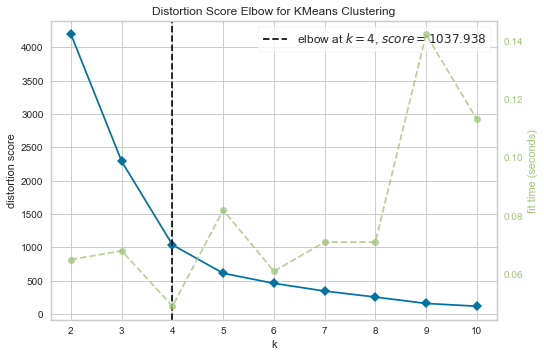

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [14]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=10)
visualizer.fit(data_matrix)
visualizer.poof()

## Silhoette Score
Hier wird der Silhouette Score berechnet um zu ermitteln 

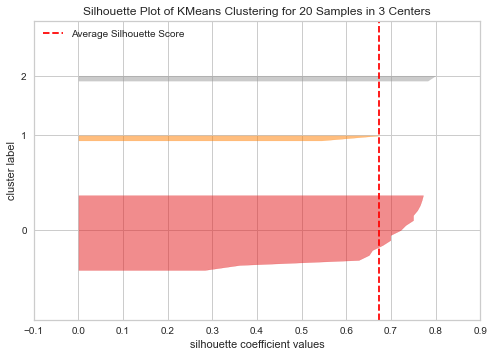

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 20 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [15]:
model = KMeans(anzahl_cluster)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(data_matrix)
visualizer.poof()

## Cluster erstellen

In [16]:
cluster = KMeans(n_clusters=anzahl_cluster).fit(data_matrix)

## Cluster als DataFrame 

In [17]:
data_cluster = pd.DataFrame({"Cluster":cluster.labels_}, index = data_matrix.index)
data_cluster.sort_values("Cluster")

,Cluster
organization,
Alibaba Group Holding Limited,0
International Business Machines Corporation,0
EMC IP Holding Company LLC,1
NEC Corporation Of America,1
"Microsoft Technology Licensing, LLC",1
Madisetti,1
MASTERCARD INTERNATIONAL INCORPORATED,1
Intel Corporation,1
Guardtime SA,1


## Ähnlichkeit berechnen
Hier wird mithilfe der scikitlearn Funktion die Kosinusähnlichkeit berechnet

In [18]:
similarity = cosine_similarity(data_matrix)

## Ähnlichkeitsmatrix in ein DataFrame überführen

In [19]:
sim_df = pd.DataFrame(similarity, index=data_matrix.index, columns = data_matrix.index)
sim_df.iloc[0:10, 0:2].head()

organization,"ADVANCED NEW TECHNOLOGIES CO., LTD.",Accenture Global Services Limited
organization,,
"ADVANCED NEW TECHNOLOGIES CO., LTD.",1.000000,0.990196
Accenture Global Services Limited,0.990196,1.000000
Alibaba Group Holding Limited,0.997281,0.992333
Bahga,0.897307,0.881556
Blockchain ASICs Inc.,0.929459,0.932568


## Erstellen eines Multiindexes
Aus Spalten und Zeilen wird nun ein Multiindex

In [20]:
sim_df = sim_df.stack()

## Pandas Series in ein DataFrame umwandeln

In [21]:
sim_df = pd.DataFrame(sim_df)
sim_df.head()

0
organization                        organization                                 
ADVANCED NEW TECHNOLOGIES CO., LTD. ADVANCED NEW TECHNOLOGIES CO., LTD.  1.000000
                                    Accenture Global Services Limited    0.990196
                                    Alibaba Group Holding Limited        0.997281
                                    Bahga                                0.897307
                                    Blockchain ASICs Inc.                0.929459

## Umbenennen der Indexe
Anschließend werden die beiden Indexe umbenannt für eine leichtere Unterscheidung im weiteren Verlauf

In [22]:
# Ähnlichkeiten im DataFrame zusammenführen
sim_df.index.rename(["Org_A", "Org_B"], inplace = True)
sim_df.head()

0
Org_A                               Org_B                                        
ADVANCED NEW TECHNOLOGIES CO., LTD. ADVANCED NEW TECHNOLOGIES CO., LTD.  1.000000
                                    Accenture Global Services Limited    0.990196
                                    Alibaba Group Holding Limited        0.997281
                                    Bahga                                0.897307
                                    Blockchain ASICs Inc.                0.929459

## Zusammenführen der beiden Spalten mit den Clustern

In [23]:
merged = sim_df.merge(data_cluster, left_on = "Org_A", right_index = True)
merged = merged.merge(data_cluster, left_on = "Org_B", right_index = True)
merged.head()

,,0,Cluster_x,Cluster_y
Org_A,Org_B,,,
"ADVANCED NEW TECHNOLOGIES CO., LTD.","ADVANCED NEW TECHNOLOGIES CO., LTD.",1.000000,2,2
Accenture Global Services Limited,"ADVANCED NEW TECHNOLOGIES CO., LTD.",0.990196,2,2
Alibaba Group Holding Limited,"ADVANCED NEW TECHNOLOGIES CO., LTD.",0.997281,0,2
Bahga,"ADVANCED NEW TECHNOLOGIES CO., LTD.",0.897307,1,2
Blockchain ASICs Inc.,"ADVANCED NEW TECHNOLOGIES CO., LTD.",0.929459,1,2


## Zurücksetzen des Indexes und Umbenennen der Spalten
Nun wird der Index zurückgesetzt und somit wird Org_a und Org_B zur normalen Spalte. Außerdem werden die Spalten zur Übersichtlichkeit umnbenannt

In [24]:
merged.reset_index(inplace = True)
merged.columns = ["Org_A", "Org_B", "Similarity", "Cluster_A", "Cluster_B"]
merged.head()

,Org_A,Org_B,Similarity,Cluster_A,Cluster_B
0,"ADVANCED NEW TECHNOLOGIES CO., LTD.","ADVANCED NEW TECHNOLOGIES CO., LTD.",1.000000,2,2
1,Accenture Global Services Limited,"ADVANCED NEW TECHNOLOGIES CO., LTD.",0.990196,2,2
2,Alibaba Group Holding Limited,"ADVANCED NEW TECHNOLOGIES CO., LTD.",0.997281,0,2
3,Bahga,"ADVANCED NEW TECHNOLOGIES CO., LTD.",0.897307,1,2
4,Blockchain ASICs Inc.,"ADVANCED NEW TECHNOLOGIES CO., LTD.",0.929459,1,2


In [25]:
##


In [26]:
merged.sort_values("Similarity",ascending=False)

,Org_A,Org_B,Similarity,Cluster_A,Cluster_B
399,"Wells Fargo Bank, N.A.","Wells Fargo Bank, N.A.",1.000000,1,1
42,Alibaba Group Holding Limited,Alibaba Group Holding Limited,1.000000,0,0
84,Blockchain ASICs Inc.,Blockchain ASICs Inc.,1.000000,1,1
90,"GSC Secrypt, LLC",Blockchain ASICs Inc.,1.000000,1,1
204,Blockchain ASICs Inc.,"GSC Secrypt, LLC",1.000000,1,1
...,...,...,...,...,...
188,"Cognitive Scale, Inc.",EMC IP Holding Company LLC,0.339827,1,1
388,"Cognitive Scale, Inc.","Wells Fargo Bank, N.A.",0.327785,1,1
179,"Wells Fargo Bank, N.A.","Cognitive Scale, Inc.",0.327785,1,1
228,"Cognitive Scale, Inc.",Guardtime SA,0.316942,1,1


In [27]:
merged.sort_values(["Cluster_A", "Cluster_B"], inplace = True)

## Zuordnung der Farben für die einzelnen Kästchen
Anhand der Ähnlichkeit wird nun die Farbe der Kästchen festgelegt

In [28]:
#palette = RdYlGn[7]
palette = RdYlGn[11]

mapper = LinearColorMapper(palette=palette, low=merged["Similarity"].min(),high=merged["Similarity"].max())

## Daten vorbereiten

In [29]:
source = ColumnDataSource(merged)

## HoverTool konfigurieren

In [30]:
hover = HoverTool(tooltips=[("Organisation 1", "@Org_A"),("Organisation 2", "@Org_B"),("Ähnlichkeit", "@Similarity")])

## Definition der Tools die Rechts neben der heatmap erscheinen

In [31]:
tools = [hover, "pan","wheel_zoom","box_zoom","reset", "save"]

## Initialisierung des Plots

In [32]:
p = figure(title="Heatmap Anmelder", x_axis_location="above", tools=tools, x_range=merged["Org_A"].unique(), y_range=list(reversed(merged["Org_B"].unique())))
p.plot_width = 800
p.plot_height = 800
p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "5pt"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = np.pi/3

## Erstellen der Heatmap

In [33]:
p.rect('Org_A', 'Org_B', 0.9, 0.9, source=source,fill_color = transform("Similarity", mapper),hover_line_color='black',hover_color = transform("Similarity", mapper))
#get_screenshot_as_png(p)


GlyphRenderer(id='1038', ...)

## Anzeigen der Heatmap

In [34]:
show(p)